# NBA Coach's Challenge

For the 2019-20 NBA season, the NBA has adopted the Coach's Challenge. Once per game, a team can challenge a called foul, called out-of-bounds violation, or called goaltending or basket interference. [This video](https://twitter.com/NBAOfficial/status/1178742322584068097?s=20) describes the process in more detail along with showing examples. [This site](https://official.nba.com/2019-20-nba-coachs-challenge-results/) shows the challenged plays by date, along with a cumulative tally of the challenge results.

The goal of this notebook is to explore the challenges that have occurred so far and use data visualization to further enhance the takeaways from the data available on the website linked above.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import itertools
from datetime import datetime, timedelta

from PIL import Image
import PIL.ImageOps    
import time

from py_ball import image, boxscore, scoreboard

HEADERS = {'Connection': 'close',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2)' + \
                         'AppleWebKit/537.36 (KHTML, like Gecko) ' + \
                         'Chrome/66.0.3359.117 Safari/537.36'}

TEAM_TO_ID_NBA = {'TOR': '1610612761', 'DEN': '1610612743',
                  'DET': '1610612765', 'NOP': '1610612740',
                  'MIL': '1610612749', 'GSW': '1610612744',
                  'SAS': '1610612759', 'POR': '1610612757',
                  'LAC': '1610612746', 'DAL': '1610612742',
                  'MEM': '1610612763', 'PHI': '1610612755',
                  'BOS': '1610612738', 'MIN': '1610612750',
                  'CHA': '1610612766', 'IND': '1610612754',
                  'ORL': '1610612753', 'MIA': '1610612748',
                  'HOU': '1610612745', 'SAC': '1610612758',
                  'UTA': '1610612762', 'BKN': '1610612751',
                  'ATL': '1610612737', 'PHX': '1610612756',
                  'WAS': '1610612764', 'NYK': '1610612752',
                  'OKC': '1610612760', 'LAL': '1610612747',
                  'CLE': '1610612739', 'CHI': '1610612741'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

In [3]:
#time.sleep(3)

Let's read in the challenge data and do some exploration. These data were sourced from the above official's challenge site that contains each play challenged this season, along with a document produced each day to summarize season-to-date challenges.

In [4]:
challenge_df = pd.read_csv('challenge.csv')
challenge_df.head()

,Date,Visiting,Home,Period,Time,Challenging Team,Challenge Type,Result,Link
0,Oct. 22,NOP,TOR,1st,2:44,TOR,Foul,Unsuccessful,https://on.nba.com/2Njm5Io
1,Oct. 22,NOP,TOR,3rd,2:41,NOP,Foul,Unsuccessful,https://on.nba.com/2N0exf2
2,Oct. 22,LAL,LAC,1st,4:56,LAL,Foul,Unsuccessful,https://on.nba.com/36sG7cu
3,Oct. 23,MEM,MIA,4th,4:57,MIA,Foul,Unsuccessful,https://on.nba.com/2BSBvON
4,Oct. 23,BOS,PHI,3rd,11:16,PHI,Foul,Unsuccessful,https://on.nba.com/2JwKQzS


Immediately, we can gather some ideas on how to visualize these data:
    - Success by team
    - Success by quarter
    - Success by challenge type
    
Additionally, we could pull in the officials in the game and examine success by officiating crew. Let's start with visualizing success by team, then tackle the other options.

## Challenges by Team

In [5]:
challenge_df['Success'] = [1 if x == 'Successful' else 0 for x in challenge_df['Result']]
team_df = pd.DataFrame(challenge_df.groupby('Challenging Team')['Success'].aggregate(['sum', 'count'])).reset_index()
team_df['success_rate'] = [0 if y == 0 else x/float(y) for x, y in zip(team_df['sum'], team_df['count'])]
for team in TEAM_TO_ID_NBA:
    if team not in list(team_df['Challenging Team']):
        temp_df = pd.DataFrame({'Challenging Team': [team],
                                'sum': [0],
                                'count': [0],
                                'success_rate': [0]})
        team_df = pd.concat([team_df, temp_df], axis=0)
team_df = team_df.sort_values(['sum', 'count', 'success_rate'], ascending=[True, True, False])
team_df

,Challenging Team,sum,count,success_rate
0,DEN,0,0,0.000000
0,SAS,0,0,0.000000
0,MEM,0,0,0.000000
0,MIN,0,0,0.000000
0,OKC,0,0,0.000000
3,CHA,0,1,0.000000
5,CLE,0,1,0.000000
6,DAL,0,1,0.000000
7,DET,0,1,0.000000
11,LAC,0,1,0.000000


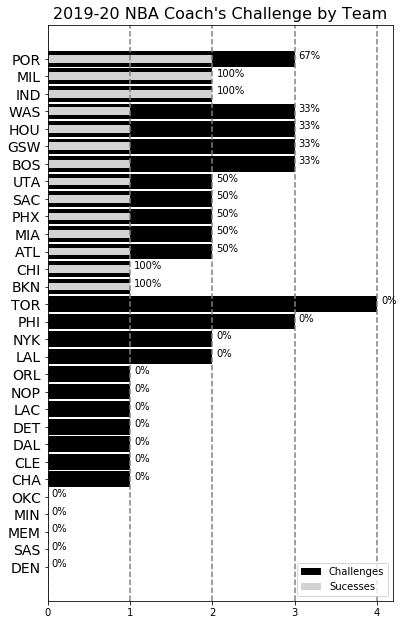

In [6]:
fig = plt.figure(figsize=(6, 8))

axis = fig.add_axes([0., 0., 0.8, 1., ])

# A nested bar chart should provide a nice visual
bar_height_po = 0.9
bar_height_league = 0.45

# Adjusting the vertical locations of the horizontal bars to match with the axis tick labels
vert_locations = np.arange(len(team_df))
#vert_locations = [x + bar_height_po/2 for x in vert_locations]

axis = fig.add_axes()

plt.barh(y=vert_locations,
        width=list(team_df['count']), height=bar_height_po,
        color='black', label = 'Challenges')
plt.barh(y=vert_locations,
        width=list(team_df['sum']), height=bar_height_league,
        color='lightgray', label = 'Sucesses')

count = 0
for perc, chal in zip(team_df['success_rate'], team_df['count']):
    plt.text(chal + 0.05, count, str(round(perc*100)) + '%')
    count += 1

plt.yticks(range(0, len(team_df)),
           team_df['Challenging Team'],
           rotation=0, fontsize=14)

plt.xticks(np.arange(0, max(team_df['count']) + 1, step=1))
for x in np.arange(0, max(team_df['count']) + 1, step=1):
    plt.axvline(x, linestyle='--', color='gray')
plt.title("2019-20 NBA Coach's Challenge by Team", fontsize=16)
plt.legend(loc='lower right')
plt.show()

The figure above shows a wide variety of both challenge usage and success. 5 teams have yet to use the coach's challenge, a peculiar finding given the low cost of a using one, which is only a timeout if the challenge is lost. 14 teams have one or fewer challenge used and no team has used a challenge in all of their games. There seems to be quite an inefficiency in challenge usage so far in the early season.

More than half of the league has yet to win a challenge, indicating that a team's reluctance to use a challenge is not leading to higher success rates. Additionally, only four teams are perfect so far, with Chicago and Brooklyn winning their only challenge and Milwaukee and Indiana winning both of their challenges. 

## Challenges by Type

In [7]:
challenge_df['Challenge Type'] = ['OB' if x == 'ob' else x for x in challenge_df['Challenge Type']]
type_df = pd.DataFrame(challenge_df.groupby('Challenge Type')['Success'].aggregate(['sum', 'count'])).reset_index()
type_df['success_rate'] = [0 if y == 0 else x/float(y) for x, y in zip(type_df['sum'], type_df['count'])]

type_df = type_df.sort_values(['sum', 'count', 'success_rate'], ascending=[True, True, False])
type_df

,Challenge Type,sum,count,success_rate
1,GT,1,2,0.500000
2,OB,4,7,0.571429
0,Foul,12,40,0.300000


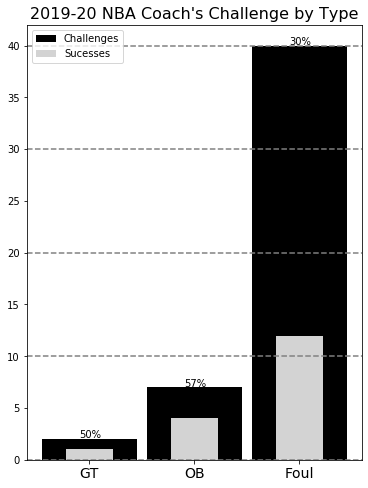

In [8]:
fig = plt.figure(figsize=(6, 8))

axis = fig.add_axes()

bar_width_po = 0.9
bar_width_league = 0.45

# Adjusting the vertical locations of the horizontal bars to match with the axis tick labels
hort_locations = np.arange(len(type_df))
#hort_locations = [x + bar_height_po/2 for x in vert_locations]

axis = fig.add_axes()

plt.bar(x=hort_locations,
        height=list(type_df['count']), width=bar_width_po,
        color='black', label = 'Challenges')
plt.bar(x=hort_locations,
        height=list(type_df['sum']), width=bar_width_league,
        color='lightgray', label = 'Sucesses')

count = 0
for perc, chal in zip(type_df['success_rate'], type_df['count']):
    plt.text(count-0.1, chal + 0.1, str(round(perc*100)) + '%')
    count += 1

plt.xticks(range(0, len(type_df)),
           type_df['Challenge Type'],
           rotation=0, fontsize=14)

plt.yticks(np.arange(0, max(type_df['count']) + 1, step=5))
for x in np.arange(0, max(type_df['count']) + 1, step=10):
    plt.axhline(x, linestyle='--', color='gray')
plt.title("2019-20 NBA Coach's Challenge by Type", fontsize=16)
plt.legend(loc='upper left')
plt.show()

This matches the data from the official NBA site and intuition. Goaltending and out-of-bounds calls are more objective than foul calls, meaning the required evidence for overturning is likely clearer. Called fouls are likely also much more ubiquitous than unlcear out-of-bounds or goaltending violations, which leads to challenges of fouls dominating the totals here. There seems to be two inefficiencies here. One, teams seem to be poor judges on foul calls against them. Two, unclear out-of-bounds reviews happen fairly frequently at the end of games, which could indicate that teams are not challenging these types of calls enough.

## Challenges by Quarter

In [9]:
quarter_df = pd.DataFrame(challenge_df.groupby('Period')['Success'].aggregate(['sum', 'count'])).reset_index()
quarter_df['success_rate'] = [0 if y == 0 else x/float(y) for x, y in zip(quarter_df['sum'], quarter_df['count'])]

quarter_df = quarter_df.sort_values(['Period'], ascending=[True])
quarter_df

,Period,sum,count,success_rate
0,1st,2,4,0.500000
1,2nd,5,12,0.416667
2,3rd,5,13,0.384615
3,4th,5,20,0.250000


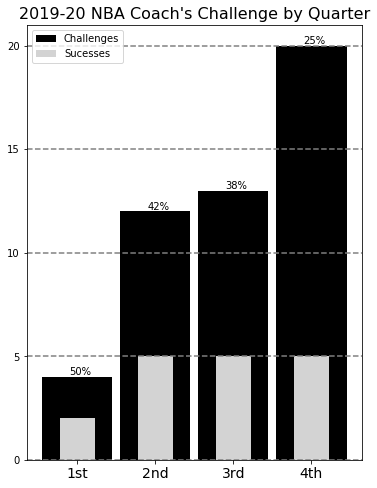

In [10]:
fig = plt.figure(figsize=(6, 8))

axis = fig.add_axes()

bar_width_po = 0.9
bar_width_league = 0.45

# Adjusting the vertical locations of the horizontal bars to match with the axis tick labels
hort_locations = np.arange(len(quarter_df))
#hort_locations = [x + bar_height_po/2 for x in vert_locations]

axis = fig.add_axes()

plt.bar(x=hort_locations,
        height=list(quarter_df['count']), width=bar_width_po,
        color='black', label = 'Challenges')
plt.bar(x=hort_locations,
        height=list(quarter_df['sum']), width=bar_width_league,
        color='lightgray', label = 'Sucesses')

count = 0
for perc, chal in zip(quarter_df['success_rate'], quarter_df['count']):
    plt.text(count-0.1, chal + 0.1, str(round(perc*100)) + '%')
    count += 1

plt.xticks(range(0, len(quarter_df)),
           quarter_df['Period'],
           rotation=0, fontsize=14)

plt.yticks(np.arange(0, max(quarter_df['count']) + 1, step=5))
for x in np.arange(0, max(quarter_df['count']) + 1, step=5):
    plt.axhline(x, linestyle='--', color='gray')
plt.title("2019-20 NBA Coach's Challenge by Quarter", fontsize=16)
plt.legend(loc='upper left')
plt.show()

Again, the above chart shows what one would expect. The volume of challenges increase by quarter. Given the low cost of a challenge, teams should be more willing to challenge a call as the end of the game approaches. Due to this, the probability of success lowers as the quarter increases.

Assuming that the rate of incorrect and challengeable plays is constant throughout a game, perhaps one could expect a more uniform distribution of challenges across quarters. This would suggest that teams are eschewing challenging calls early in the game in favor of saving the challenge should a more impactful situation arise. But given the declining rate of success across the game, these situations either arise less frequently as teams believe or their inability to identify them is poor.

## Challenges by Officiating Crew

The official's challenge website does not include the officiating crew for each game, so this must be pulled from the boxscore data and joined to the challenge data. First, let's get today's date and pull in officiating crew information for all games.

In [11]:
league_id = '00' #NBA
date = datetime.today() - timedelta(days=2)
years = str(date.year)
if date.month <= 9:
    month = '0' + str(date.month)
else:
    month = str(date.month)
if date.day <= 9:
    day_str = '0' + str(date.day)
else:
    day_str = str(date.day)

date_str = month + '/' + day_str + '/' + years
day_offset = '0'

scores = scoreboard.ScoreBoard(headers=HEADERS,
                               endpoint='scoreboardv2',
                               league_id=league_id,
                               game_date=date_str,
                               day_offset=day_offset)

game_id_list = [int(x['GAME_ID']) for x in scores.data['GameHeader']]
max_game = max(game_id_list)

KeyboardInterrupt: 

In [ ]:
max_game

In [ ]:
ref_df = pd.DataFrame()
for game_id in range(21900001, max_game + 1):
    print(game_id)
    plays = boxscore.BoxScore(headers=HEADERS,
                             endpoint='boxscoresummaryv2',
                             game_id='00' + str(game_id))
    
    official_df = pd.DataFrame(plays.data['Officials']).sort_values('OFFICIAL_ID')
    official_df['NAME'] = [x + ' ' + y for x, y in zip(official_df['FIRST_NAME'],
                                                       official_df['LAST_NAME'])]
    official_str = ''
    name_str = ''
    for official, name in zip(official_df['OFFICIAL_ID'], official_df['NAME']):
        official_str += str(official)
        name_str += name
        if official != list(official_df['OFFICIAL_ID'])[-1]:
            official_str += '-'
            name_str += '-'
            
    game_date = plays.data['GameSummary'][0]['GAME_DATE_EST'].replace('T00:00:00', '')
    away_team = plays.data['GameSummary'][0]['GAMECODE'][-6:-3]
    home_team = plays.data['GameSummary'][0]['GAMECODE'][-3:]

    temp_df = pd.DataFrame({'OFFICIALS': [official_str],
                            'NAMES': [name_str],
                            'GAME_DATE': [game_date],
                            'AWAY_TEAM': [away_team],
                            'HOME_TEAM': [home_team]})
    ref_df = pd.concat([ref_df, temp_df], axis=0)
    time.sleep(1.5)

In [ ]:
ref_df

,OFFICIALS,NAMES,GAME_DATE,AWAY_TEAM,HOME_TEAM
0,2529-200833-201639,Tony Brown-Eric Dalen-Josh Tiven,2019-10-22,NOP,TOR
0,200834-201640-203592,Mark Lindsay-Kane Fitzgerald-Dedric Taylor,2019-10-22,LAL,LAC
0,1179-1188-204058,Rodney Mott-Leroy Richardson-Gediminas Petraitis,2019-10-23,CHI,CHA
0,1830-202035-202049,Marc Davis-Brett Nansel-Ben Taylor,2019-10-23,DET,IND
0,2715-201637-201638,Eric Lewis-Haywoode Workman-Brent Barnaky,2019-10-23,CLE,ORL
0,1204-2003-202041,Derek Richardson-Pat Fraher-Kevin Scott,2019-10-23,MIN,BKN
0,101284-202026-1628481,John Goble-Karl Lane-Simone Jelks,2019-10-23,MEM,MIA
0,1151-2882-201245,Sean Corbin-Sean Wright-Marat Kogut,2019-10-23,BOS,PHI
0,1174-202007-1627964,Ken Mauer-Nick Buchert-Jonathan Sterling,2019-10-23,WAS,DAL
0,2714-202053-1628954,David Guthrie-Scott Twardoski-Jenna Schroeder,2019-10-23,NYK,SAS


In [ ]:
time.sleep()

TypeError: 'int' object is not callable

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG
99,0021900001,137,18,4,1,8:27 PM,2:44,None,None,None,...,None,None,1,0,None,NaN,None,None,None,0
365,0021900001,514,18,4,3,9:49 PM,2:39,None,None,None,...,None,None,1,0,None,NaN,None,None,None,0
495,0021900001,692,18,0,4,10:27 PM,2:14,None,None,None,...,None,None,1,0,None,NaN,None,None,None,0
